### 1. Imports

In [1]:
import sdv

In [2]:
NUM_ROWS = 5110
NUM_EPOCHS = 1000

### 2. Load data

In [3]:
from sdv.datasets.local import load_csvs

# This is the default folder name that the GOogle Colab notebook uses.
# Change this if you have your own folder with CSV files.

data = load_csvs(
    folder_name='../../data/examples/',
    read_csv_parameters={}
    )

In [4]:
data.keys()

dict_keys(['healthcare-dataset-stroke-data'])

### 3. Preprocesing

In [ ]:
df = data['healthcare-dataset-stroke-data']
df['age'] = df['age'].astype('int64')

# use the head method to inspect the first few rows of the data
df.head(3)

id  gender  age  hypertension  heart_disease ever_married  \
0   9046    Male   67             0              1          Yes   
1  51676  Female   61             0              0          Yes   
2  31112    Male   80             0              1          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   

   stroke  
0       1  
1       1  
2       1

In [6]:
df.dtypes

id                     int64
gender                object
age                    int64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [7]:
from sdv.metadata import Metadata

metadata = Metadata.detect_from_dataframes(data)

Auto detected data:



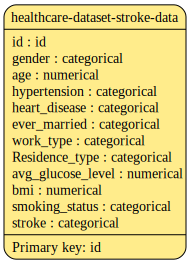

In [8]:
print('Auto detected data:\n')
metadata.visualize()

In [9]:
metadata.update_column(
    column_name='age',
    sdtype='numerical',
    table_name='healthcare-dataset-stroke-data',
    computer_representation='Int8')

In [10]:
metadata.validate()

In [11]:
metadata.validate_data(data=data)

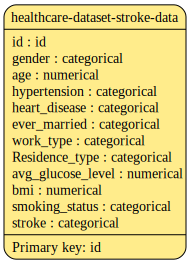

In [12]:
metadata.visualize()

In [13]:
import os
if os.path.exists("metadata.json"):
  os.remove("metadata.json")

metadata.save_to_json('metadata.json')
# in the future, you can reload the metadata object from the file
metadata = Metadata.load_from_json('metadata.json')

### 4. Synthesizers

#### 4.1. GaussianCopulaSynthesizer

In [14]:
from sdv.single_table import GaussianCopulaSynthesizer

gc_synthesizer = GaussianCopulaSynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    locales=["es_ES"],
    numerical_distributions={},
    default_distribution='norm'
)

In [15]:
gc_synthesizer.fit(df)

In [16]:
gc_synthetic_data = gc_synthesizer.sample(num_rows=NUM_ROWS)

In [17]:
gc_synthetic_data.to_csv(
    '../../data/synthetic/gc.csv',
    index=False
)

#### 4.2.CTGANSynthesizer

In [18]:
from sdv.single_table import CTGANSynthesizer

ctgan_synthesizer = CTGANSynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    locales=['es_ES'],
    epochs=NUM_EPOCHS,
    verbose=True,
    cuda=True
)

In [19]:
ctgan_synthesizer.fit(df)

Gen. (-0.75) | Discrim. (-0.10): 100%|██████████| 1000/1000 [11:54<00:00,  1.40it/s]


In [20]:
ctgan_synthetic_data = ctgan_synthesizer.sample(num_rows=NUM_ROWS)

In [21]:
ctgan_synthetic_data.to_csv(
    '../../data/synthetic/ctgan.csv',
    index=False
)

#### 4.3. TVAESynthesizer

In [22]:
from sdv.single_table import TVAESynthesizer

tvaes_synthesizer = TVAESynthesizer(
    metadata,
    enforce_min_max_values=False,
    enforce_rounding=True,
    epochs=NUM_EPOCHS,
    verbose=True,
    cuda=True
)

In [23]:
tvaes_synthesizer.fit(df)

Loss: 6.744:  24%|██▍       | 241/1000 [01:11<03:44,  3.38it/s] 


KeyboardInterrupt: 

In [24]:
tvaes_synthetic_data = tvaes_synthesizer.sample(num_rows=NUM_ROWS)

In [25]:
tvaes_synthetic_data.to_csv(
    '../../data/synthetic/tvaes.csv',
    index=False
)

### 5. Evaluating Real vs. Synthetic Data

#### 5.1. GaussianCopulaSynthesizer

In [26]:
from sdv.evaluation.single_table import run_diagnostic

gc_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=gc_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 1192.30it/s]|
Data Validity Score: 98.28%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 89.58it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.14%



In [27]:
from sdv.evaluation.single_table import evaluate_quality

gc_quality_report = evaluate_quality(
    df,
    gc_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 250.06it/s]|
Column Shapes Score: 94.19%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 221.22it/s]|
Column Pair Trends Score: 68.12%

Overall Score (Average): 81.16%



In [28]:
gc_details = gc_quality_report.get_details('Column Pair Trends')
gc_details[gc_details['Real Correlation'].notnull()]

Column 1           Column 2                 Metric     Score  \
15                age  avg_glucose_level  CorrelationSimilarity  0.998052   
16                age                bmi  CorrelationSimilarity  0.994195   
49  avg_glucose_level                bmi  CorrelationSimilarity  0.989240   

    Real Correlation  Synthetic Correlation  
15          0.238060               0.241956  
16          0.333738               0.322128  
49          0.175502               0.153982

In [29]:
gc_quality_report.get_details('Column Shapes')

Column        Metric     Score
0              gender  TVComplement  0.955186
1                 age  KSComplement  0.948728
2        hypertension  TVComplement  0.980626
3       heart_disease  TVComplement  0.992759
4        ever_married  TVComplement  0.949706
5           work_type  TVComplement  0.901174
6      Residence_type  TVComplement  0.995108
7   avg_glucose_level  KSComplement  0.810959
8                 bmi  KSComplement  0.941028
9      smoking_status  TVComplement  0.895303
10             stroke  TVComplement  0.990215

In [ ]:
from sdv.evaluation.single_table import get_column_plot

plot_columns = list(df.columns)
plot_columns.remove("id")

for column in plot_columns:
    fig = get_column_plot(
        real_data=df,
        synthetic_data=gc_synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()

#### 5.2. CTGANSynthesizer

In [31]:
ctgan_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=ctgan_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 1072.69it/s]|
Data Validity Score: 99.27%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 248.96it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.64%



In [32]:
ctgan_quality_report = evaluate_quality(
    df,
    ctgan_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 212.67it/s]|
Column Shapes Score: 93.59%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 175.47it/s]|
Column Pair Trends Score: 83.3%

Overall Score (Average): 88.44%



In [33]:
ctgan_details = ctgan_quality_report.get_details('Column Pair Trends')
ctgan_details[ctgan_details['Real Correlation'].notnull()]

Column 1           Column 2                 Metric     Score  \
15                age  avg_glucose_level  CorrelationSimilarity  0.999158   
16                age                bmi  CorrelationSimilarity  0.960478   
49  avg_glucose_level                bmi  CorrelationSimilarity  0.962383   

    Real Correlation  Synthetic Correlation  
15          0.238060               0.239744  
16          0.333738               0.412783  
49          0.175502               0.250736

In [34]:
ctgan_quality_report.get_details('Column Shapes')

Column        Metric     Score
0              gender  TVComplement  0.966928
1                 age  KSComplement  0.913894
2        hypertension  TVComplement  0.826614
3       heart_disease  TVComplement  0.932681
4        ever_married  TVComplement  0.979256
5           work_type  TVComplement  0.946575
6      Residence_type  TVComplement  0.929941
7   avg_glucose_level  KSComplement  0.953033
8                 bmi  KSComplement  0.924122
9      smoking_status  TVComplement  0.946380
10             stroke  TVComplement  0.975538

In [ ]:
for column in plot_columns:
    fig = get_column_plot(
        real_data=df,
        synthetic_data=ctgan_synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()

#### 5.3. TVAESSynthesizer

In [36]:
tvaes_diagnostic = run_diagnostic(
    real_data=df,
    synthetic_data=tvaes_synthetic_data,
    metadata=metadata
)

Generating report ...

(1/2) Evaluating Data Validity: |██████████| 12/12 [00:00<00:00, 1104.35it/s]|
Data Validity Score: 99.96%

(2/2) Evaluating Data Structure: |██████████| 1/1 [00:00<00:00, 385.54it/s]|
Data Structure Score: 100.0%

Overall Score (Average): 99.98%



In [37]:
tvaes_quality_report = evaluate_quality(
    df,
    tvaes_synthetic_data,
    metadata
)

Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 12/12 [00:00<00:00, 172.21it/s]|
Column Shapes Score: 93.51%

(2/2) Evaluating Column Pair Trends: |██████████| 66/66 [00:00<00:00, 185.11it/s]|
Column Pair Trends Score: 83.7%

Overall Score (Average): 88.6%



In [38]:
tvaes_details = tvaes_quality_report.get_details('Column Pair Trends')
tvaes_details[tvaes_details['Real Correlation'].notnull()]

Column 1           Column 2                 Metric     Score  \
15                age  avg_glucose_level  CorrelationSimilarity  0.927147   
16                age                bmi  CorrelationSimilarity  0.998417   
49  avg_glucose_level                bmi  CorrelationSimilarity  0.881031   

    Real Correlation  Synthetic Correlation  
15          0.238060               0.383767  
16          0.333738               0.336904  
49          0.175502               0.413439

In [39]:
tvaes_quality_report.get_details('Column Shapes')

Column        Metric     Score
0              gender  TVComplement  0.999609
1                 age  KSComplement  0.896869
2        hypertension  TVComplement  0.946771
3       heart_disease  TVComplement  0.960861
4        ever_married  TVComplement  0.971624
5           work_type  TVComplement  0.783953
6      Residence_type  TVComplement  0.987867
7   avg_glucose_level  KSComplement  0.867319
8                 bmi  KSComplement  0.949587
9      smoking_status  TVComplement  0.967319
10             stroke  TVComplement  0.954599

In [ ]:
for column in plot_columns:
    fig = get_column_plot(
        real_data=df,
        synthetic_data=tvaes_synthetic_data,
        column_name=column,
        metadata=metadata
    )
    fig.show()